# Image Clustering with ImageBind Embeddings

## Assignment H
**Goal:** Write a colab for clustering with images using ImageBind LLM embeddings.

**Dataset:** [CIFAR-10](https://paperswithcode.com/dataset/cifar-10) (We use a subset for demonstration).

**Note:** This notebook requires a GPU runtime.

In [1]:
# Install ImageBind and dependencies
!pip install -q git+https://github.com/facebookresearch/ImageBind.git
!pip install -q torch torchvision torchaudio

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 47.3 MB/s eta 0:00:00


In [2]:
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Check for GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


## 1. Load ImageBind Model
We load the pretrained ImageBind model.

In [3]:
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

100%|██████████| 4.47G/4.47G [00:18<00:00, 258MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

## 2. Load Data (CIFAR-10)
We download CIFAR-10 and save a subset of images to disk because ImageBind expects file paths.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select a subset: 10 images from first 5 classes
classes = cifar10.classes
selected_indices = []
selected_labels = []
image_paths = []

os.makedirs("cifar_subset", exist_ok=True)

count_per_class = {i: 0 for i in range(5)}
for i in range(len(cifar10)):
    img, label = cifar10[i]
    if label < 5 and count_per_class[label] < 10:
        # Save image to disk
        img_pil = transforms.ToPILImage()(img)
        path = f"cifar_subset/img_{i}_class_{classes[label]}.jpg"
        img_pil.save(path)
        image_paths.append(path)
        selected_labels.append(label)
        count_per_class[label] += 1
    if all(c >= 10 for c in count_per_class.values()):
        break

print(f"Selected {len(image_paths)} images from {len(set(selected_labels))} classes.")

100%|██████████| 170M/170M [00:02<00:00, 71.8MB/s]


Selected 50 images from 5 classes.


## 3. Extract Embeddings
We use ImageBind to extract vision embeddings.

In [5]:
inputs = {ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device)}

with torch.no_grad():
    embeddings = model(inputs)

vision_embeddings = embeddings[ModalityType.VISION].cpu().numpy()
print(f"Embeddings shape: {vision_embeddings.shape}")

Embeddings shape: (50, 1024)


## 4. Cluster Images
We use K-Means to cluster the embeddings.

In [6]:
kmeans = KMeans(n_clusters=5, random_state=17, n_init=15)
pred_labels = kmeans.fit_predict(vision_embeddings)

## 5. Visual Analysis
We use t-SNE to visualize the clusters.

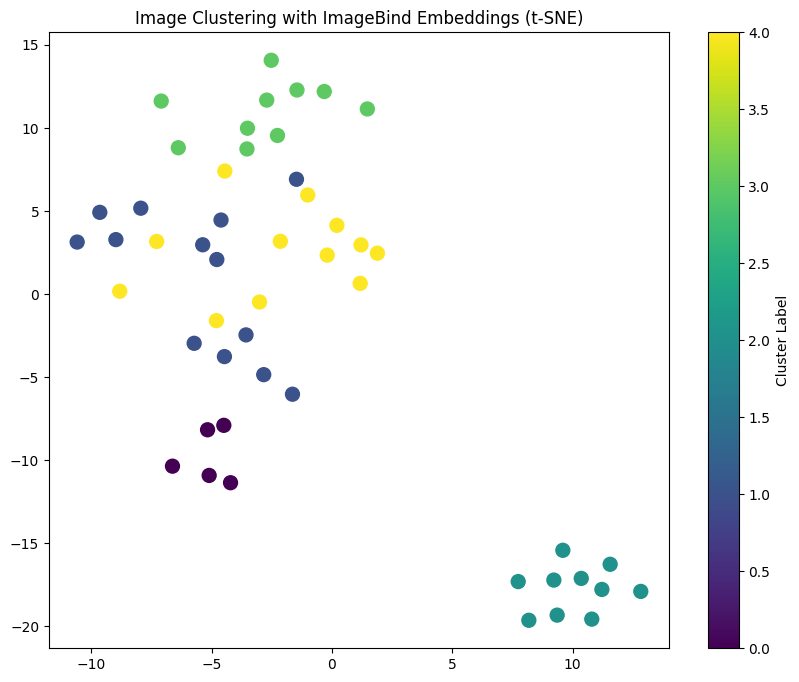

In [7]:
tsne = TSNE(n_components=2, perplexity=10, random_state=17)
embeddings_2d = tsne.fit_transform(vision_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=pred_labels, cmap='viridis', s=100)
plt.title('Image Clustering with ImageBind Embeddings (t-SNE)')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

## 6. Evaluation
Compare with ground truth labels.

In [8]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(selected_labels, pred_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.4438
